In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import xml.etree.ElementTree as ET

from xml.dom.minidom import parse
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Preparation

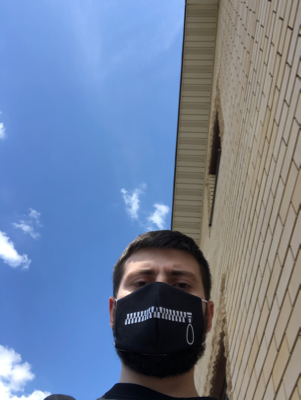

In [2]:
# dataset path
images_path = 'Datasets/face-mask-detection/images/'
annot_path = 'Datasets/face-mask-detection/annotations/'

# take image sample
sample_image_filename = np.random.choice(os.listdir(images_path))

image_sample = tf.keras.preprocessing.image.load_img(
    images_path + sample_image_filename
)
image_sample

In [3]:
# take annotation sample
# sample_annot_filename = np.random.choice(os.listdir(annot_path))
sample_annot_filename = sample_image_filename.replace('png', 'xml')

with open(annot_path + sample_annot_filename, 'r') as f:
    read_xml = f.read()

print(read_xml)


<annotation>
    <folder>images</folder>
    <filename>maksssksksss814.png</filename>
    <size>
        <width>301</width>
        <height>400</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>114</xmin>
            <ymin>262</ymin>
            <xmax>207</xmax>
            <ymax>379</ymax>
        </bndbox>
    </object>
</annotation>


In [4]:
# traverse to get class name(s) and bounding box(es)
tree = ET.parse(annot_path + sample_annot_filename)
root = tree.getroot()

sample_annot = []

for neighbor in root.iter('object'):
    print(neighbor.find('name').text)
    
for neighbor in root.iter('bndbox'):
    xmin = int(neighbor.find('xmin').text)
    ymin = int(neighbor.find('ymin').text)
    xmax = int(neighbor.find('xmax').text)
    ymax = int(neighbor.find('ymax').text)
    
    sample_annot.append([xmin, ymin, xmax, ymax])
    
print(sample_annot)

with_mask
[[114, 262, 207, 379]]


In [5]:
# alternative way to traverse

dom = parse(annot_path + sample_annot_filename)
root = dom.documentElement
root.getElementsByTagName(
    'object'
)[0].getElementsByTagName('name')[0].childNodes[0].data

'with_mask'

In [6]:
# original_shape = image_sample_arr.shape
# image_sample_arr = tf.keras.preprocessing.image.img_to_array(
#     image_sample_arr.reshape(
#         1, original_shape[0],
#         original_shape[1], original_shape[2]
#     )
# )
# colors = np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
# tf.image.draw_bounding_boxes(
#     image_sample_arr,
#     sample_annot, colors)

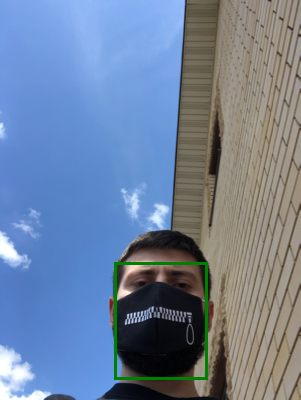

In [7]:
img_ = ImageDraw.Draw(image_sample)

for bndbox in sample_annot:
    img_.rectangle(bndbox, outline='green', width=3)
image_sample

In [8]:
# traverse through image and annotation files
# img_data = []
labels = []
img_data = np.array([])
# labels = np.array([])
img_names = []
img_paths = []
bnxboxes = []

# for each annotation file
for annot_filename in os.listdir(annot_path):
    # get xml and png file path
    img_name = annot_filename.replace('.xml', '')
    xml_file_path = annot_path + annot_filename
    png_file_path = (images_path + annot_filename).replace('xml', 'png')
    
    # load the image to array
    img = tf.keras.preprocessing.image.load_img(png_file_path)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # parse the xml file
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    
    # store current image labels and bounding boxes
    curr_labels = []
    curr_bnxboxes = []
    
    # get image size to help rescaling later
    for neighbor in root.iter('size'):
        curr_width = int(neighbor.find('width').text)
        curr_height = int(neighbor.find('height').text)
    
    # get label and bounding box
    for neighbor in root.iter('object'):
        # CURRENT LIMITATION: single label per image
        # pick the first seen label
        label = neighbor.find('name').text
        # curr_labels.append(label)
        curr_labels = label
    
        # get the first seen bounding box
        for neighbor in root.iter('bndbox'):
            # rescale the box size
            xmin = int(neighbor.find('xmin').text) / curr_width
            ymin = int(neighbor.find('ymin').text) / curr_height
            xmax = int(neighbor.find('xmax').text) / curr_width
            ymax = int(neighbor.find('ymax').text) / curr_height
            
            # curr_bndboxes.append(np.array[[xmin, ymin, xmax, ymax]])
            curr_bndboxes = np.array([[xmin, ymin, xmax, ymax]], dtype=np.float32)
            break
            
    # append current image array, filename, path, label, and bounding box
    # img_data.append(img_array)
    labels.append(curr_labels)
    
    resized_img_array = tf.image.resize(
        [img_array], [224,224]
    ).numpy()[0]
    
    if len(img_data) == 0:
        img_data = np.expand_dims(resized_img_array, axis=0)
    else:
        img_data = np.insert(img_data, 1, resized_img_array, axis=0)
    
    img_names.append(img_name)
    img_paths.append(png_file_path)
    bnxboxes.append(curr_bndboxes)

2021-11-04 16:07:10.163633: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-04 16:07:10.164440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [9]:
# label encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# train test split
splits = train_test_split(
    img_data, encoded_labels, bnxboxes, img_paths,
    test_size=0.2, random_state=22, stratify=encoded_labels
)

train_images, test_images = splits[:2]
train_labels, test_labels = splits[2:4]
train_boxes, test_boxes = splits[4:6]
train_paths, test_paths = splits[6:]

In [10]:
# pass the image arrays to tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_images, (train_labels, train_boxes))
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_images, (test_labels, test_boxes))
)

## Model Training

### Xception

In [11]:
# define the model with Xception
n_classes = len(np.unique(train_labels))
base_model = tf.keras.applications.xception.Xception(
    weights='imagenet', include_top=False
)
avg_pool = tf.keras.layers.GlobalAveragePooling2D()(
    base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation='softmax')(avg_pool)
loc_output = tf.keras.layers.Dense(4)(avg_pool)
model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=[class_output, loc_output]
)

model.compile(
    loss=['sparse_categorical_crossentropy', 'mse'],
    loss_weights=[0.8, 0.2],
    optimizer='sgd', metrics=['accuracy', 'mae']
)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [13]:
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 100

train_dataset_batched = train_dataset.shuffle(
    SHUFFLE_BUFFER_SIZE
).batch(BATCH_SIZE)

test_dataset_batched = test_dataset.batch(BATCH_SIZE)

In [14]:
model.fit(train_dataset_batched, epochs=5)

Epoch 1/5


2021-11-04 16:09:29.993342: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-04 16:09:30.002690: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-04 16:09:30.003329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 47s 1s/step - loss: 0.6751 - dense_loss: 0.8151 - dense_1_loss: 0.1149 - dense_accuracy: 0.6891 - dense_mae: 0.8666 - dense_1_accuracy: 0.4373 - dense_1_mae: 0.2712
Epoch 2/5
43/43 [==============================] - 45s 1s/step - loss: 0.5561 - dense_loss: 0.6704 - dense_1_loss: 0.0991 - dense_accuracy: 0.7434 - dense_mae: 0.8666 - dense_1_accuracy: 0.4213 - dense_1_mae: 0.2516
Epoch 3/5
43/43 [==============================] - 45s 1s/step - loss: 0.4993 - dense_loss: 0.5997 - dense_1_loss: 0.0975 - dense_accuracy: 0.7434 - dense_mae: 0.8666 - dense_1_accuracy: 0.4237 - dense_1_mae: 0.2488
Epoch 4/5
43/43 [==============================] - 46s 1s/step - loss: 0.4559 - dense_loss: 0.5460 - dense_1_loss: 0.0954 - dense_accuracy: 0.7434 - dense_mae: 0.8666 - dense_1_accuracy: 0.4219 - dense_1_mae: 0.2464
Epoch 5/5
43/43 [==============================] - 45s 1s/step - loss: 0.4196 - dense_loss: 0.5009 - dense_1_loss: 0.0946 - dense_accuracy: 0.7434

In [17]:
pd.DataFrame(model.history.history)

,loss,dense_loss,dense_1_loss,dense_accuracy,dense_mae,dense_1_accuracy,dense_1_mae
0,0.675079,0.815125,0.114899,0.689150,0.866569,0.437339,0.271181
1,0.556109,0.670356,0.099123,0.743402,0.866569,0.421305,0.251617
2,0.499304,0.599745,0.097541,0.743402,0.866569,0.423701,0.248809
3,0.455899,0.546026,0.095393,0.743402,0.866569,0.421950,0.246425
4,0.419635,0.500902,0.094569,0.743402,0.866569,0.413841,0.246229


In [ ]:
# TODO: implement draw predicted box function



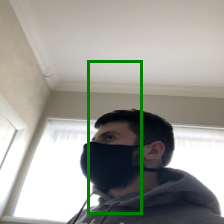

In [116]:
test_single = test_dataset_batched.take(1)
predicted = model.predict(test_single)

test_single_data = test_single.as_numpy_iterator().next()
test_single_img_1 = test_single_data[0][0]
test_single_box_1 = test_single_data[1][0]

test_single_img_1 = tf.keras.preprocessing.image.array_to_img(test_single_img_1)
curr_img = ImageDraw.Draw(test_single_img_1)

curr_img.rectangle(predicted[1][0] * 224, outline='green', width=3)
test_single_img_1